In [1]:
!pip install mamimo


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# An Example Dataset and Simple Modeling

In [2]:
# https://github.com/Garve/datasets/blob/4576d323bf2b66c906d5130d686245ad205505cf/mmm.csv

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
import pandas as pd
data = pd.read_csv(
    'https://raw.githubusercontent.com/Garve/datasets/4576d323bf2b66c906d5130d686245ad205505cf/mmm.csv',
    parse_dates=['Date'],
    index_col='Date'
)
X = data.drop(columns=['Sales'])
y = data['Sales']
lr = LinearRegression()
print(cross_val_score(lr, X, y, cv=TimeSeriesSplit()))

[0.69594303 0.69302285 0.66850729 0.78807363 0.73512387]


In [4]:
lr.fit(X, y) # refit the model with the complete dataset
print('Coefficients:', lr.coef_)
print('Intercept:', lr.intercept_)

Coefficients: [0.35968382 0.48833246 1.2159193 ]
Intercept: 6678.396933606161


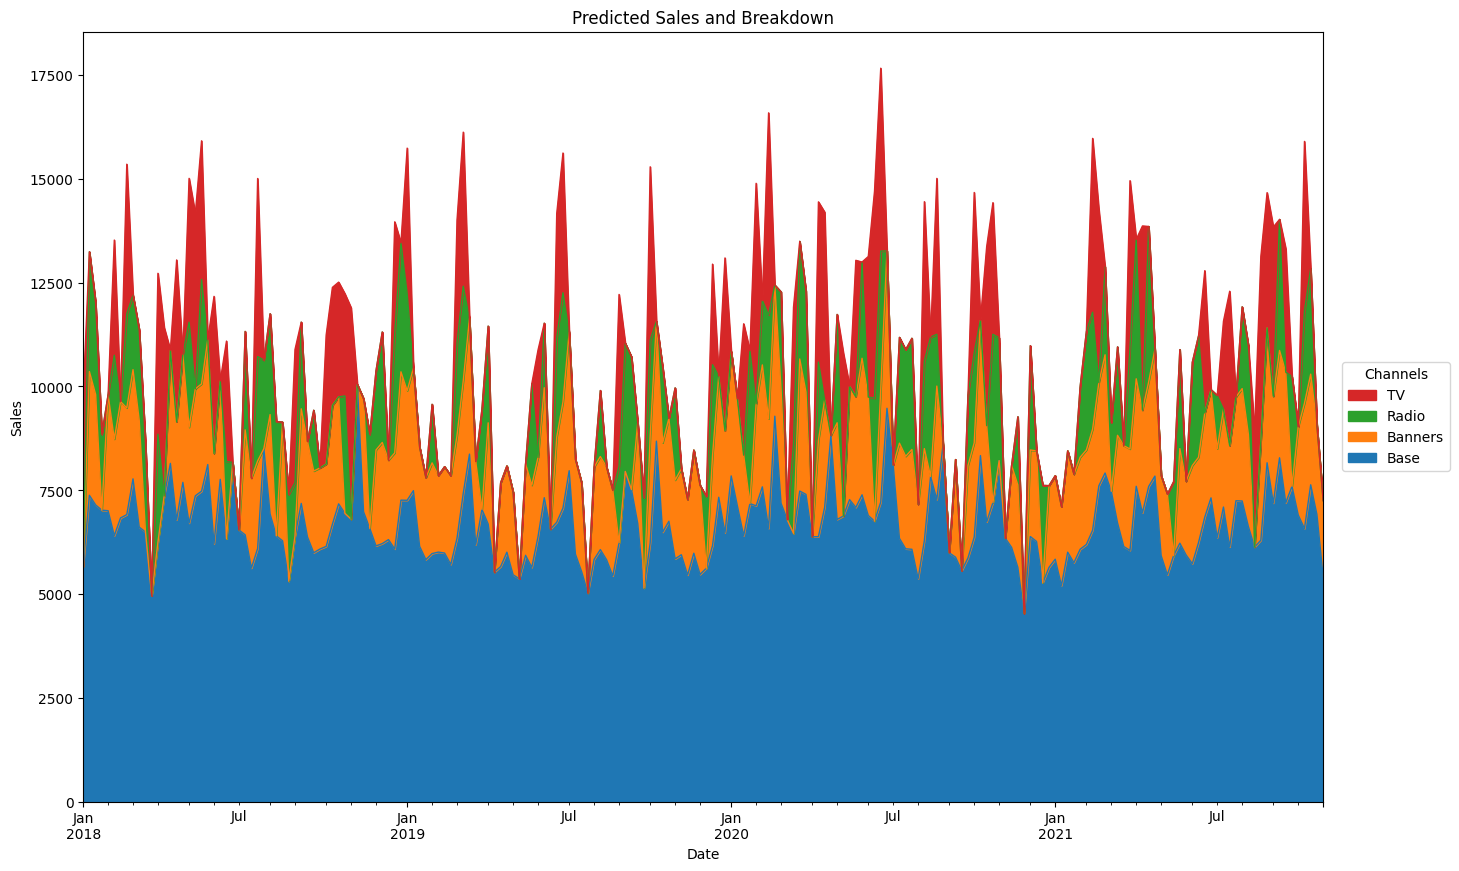

In [5]:
weights = pd.Series(
    lr.coef_,
    index=X.columns
)
base = lr.intercept_
unadj_contributions = X.mul(weights).assign(Base=base)
adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    ) # contains all contributions for each day
ax = (adj_contributions[['Base', 'Banners', 'Radio', 'TV']]
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Sales and Breakdown',
          ylabel='Sales',
          xlabel='Date')
     )
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)

In [6]:
sales_from_tv = adj_contributions['TV'].sum()
spendings_on_tv = data['TV'].sum()
tv_roi = sales_from_tv / spendings_on_tv
tv_roi.round(2)

0.36

Problems With This Simple Approach
While the above approach seems reasonable, it has certain shortcomings that we have to address:

- The performance could be better. Sometimes, there is nothing we can do about bad performance because it depends on the data a lot, but we should try our best anyway.

- Even more severe: The model itself definitely does not reflect reality. According to the linear formula, we can drive sales as high as we want by spending more and more money on advertising. Since the banners have a high coefficient of 1.23, for each 1$ we spend in this channel we generate 1.23$ additional sales. Repeat for infinite money, customers will hate this trick!

- Optimizing becomes trivial and unrealistic as well. To maximize sales, we would now put all the money into the web banners channel because it has the highest coefficient. We would abandon TV and radio advertising altogether which may be not the right thing to do if the company wants to retain its awareness among people.

# Effect of diminishing returns

In [7]:
class ExponentialSaturation:
    def __init__(self, a=1.):
        self.a = a
        
    def transform(self, X):
        return 1 - np.exp(-self.a*X)

In [8]:
#Building Saturation and Carry-Over Effects in scikit-learn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted, check_array
class ExponentialSaturation(BaseEstimator, TransformerMixin):
    def __init__(self, a=1.):
        self.a = a
        
    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True) # from BaseEstimator
        return self
    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False) # from BaseEstimator
        return 1 - np.exp(-self.a*X)

# Creating a Carry-Over Effect

In [9]:
from scipy.signal import convolve2d
import numpy as np
class ExponentialCarryover(BaseEstimator, TransformerMixin):
    def __init__(self, strength=0.5, length=1):
        self.strength = strength
        self.length = length
    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True)
        self.sliding_window_ = (
            self.strength ** np.arange(self.length + 1)
        ).reshape(-1, 1)
        return self
    def transform(self, X: np.ndarray):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False)
        convolution = convolve2d(X, self.sliding_window_)
        if self.length > 0:
            convolution = convolution[: -self.length]
        return convolution

# The Final Model Pipeline

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
adstock = ColumnTransformer(
    [
     ('tv_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['TV']),
     ('radio_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['Radio']),
     ('banners_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['Banners']),
    ],
    remainder='passthrough'
)
model = Pipeline([
                  ('adstock', adstock),
                  ('regression', LinearRegression())
])

In [11]:
import pandas as pd
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
data = pd.read_csv(
    'https://raw.githubusercontent.com/Garve/datasets/4576d323bf2b66c906d5130d686245ad205505cf/mmm.csv',
    parse_dates=['Date'],
    index_col='Date'
)
X = data.drop(columns=['Sales'])
y = data['Sales']
model.fit(X, y)
print(cross_val_score(model, X, y, cv=TimeSeriesSplit()).mean().round(2))

0.55


In [14]:
from optuna.integration import OptunaSearchCV
from optuna.distributions import UniformDistribution, IntUniformDistribution
tuned_model = OptunaSearchCV(
    estimator=model,
    param_distributions={
        'adstock__tv_pipe__carryover__strength': UniformDistribution(0, 1),
        'adstock__tv_pipe__carryover__length': IntUniformDistribution(0, 6),
        'adstock__tv_pipe__saturation__a': UniformDistribution(0, 0.01),
        'adstock__radio_pipe__carryover__strength': UniformDistribution(0, 1),
        'adstock__radio_pipe__carryover__length': IntUniformDistribution(0, 6),
        'adstock__radio_pipe__saturation__a': UniformDistribution(0, 0.01),
        'adstock__banners_pipe__carryover__strength': UniformDistribution(0, 1),
        'adstock__banners_pipe__carryover__length': IntUniformDistribution(0, 6),
        'adstock__banners_pipe__saturation__a': UniformDistribution(0, 0.01),
    },
    n_trials=1000,
    cv=TimeSeriesSplit(),
    random_state=0
)

c:\Users\L48371\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\L48371\AppData\Local\Temp\ipykernel_26728\1087310806.py:6: FutureWarning: UniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :class:`~optuna.distributions.FloatDistribution` instead.
  'adstock__tv_pipe__carryover__strength': UniformDistribution(0, 1),
C:\Users\L48371\AppData\Local\Temp\ipykernel_26728\1087310806.py:7: FutureWarning: IntUniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :class:`~optuna.distributions.IntDistribution` instead.
  'adstock__tv_pipe__carryover__length': IntUniformDistributio

In [18]:
tuned_model.fit(X, y)


[I 2022-10-27 13:56:54,980] A new study created in memory with name: no-name-124f020e-d9be-4c1e-bd78-390a6290379e
[I 2022-10-27 13:56:55,125] Trial 0 finished with value: 0.13779163981195117 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4860473230215504, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.009855760506615989, 'adstock__radio_pipe__carryover__strength': 0.1955964101622225, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 0.00980582177099305, 'adstock__banners_pipe__carryover__strength': 0.18048029738995275, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.008463095456331128}. Best is trial 0 with value: 0.13779163981195117.
[I 2022-10-27 13:56:55,236] Trial 1 finished with value: -7.206841484775084e+17 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7967092952533198, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0

OptunaSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
               estimator=Pipeline(steps=[('adstock',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('tv_pipe',
                                                                           Pipeline(steps=[('carryover',
                                                                                            ExponentialCarryover()),
                                                                                           ('saturation',
                                                                                            ExponentialSaturation())]),
                                                                           ['TV']),
                                                                          ('radio_pipe',
                                                                

In [19]:
print(tuned_model.best_params_)
print(tuned_model.best_estimator_.named_steps['regression'].coef_)
print(tuned_model.best_estimator_.named_steps['regression'].intercept_)

{'adstock__tv_pipe__carryover__strength': 0.5248878517291329, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 1.4649722346562529e-05, 'adstock__radio_pipe__carryover__strength': 0.45523455448406197, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0001974038926379962, 'adstock__banners_pipe__carryover__strength': 0.3340342963936898, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007256873558015173}
[27926.6810003   4114.46117033  2537.18883927]
5348.966158957056


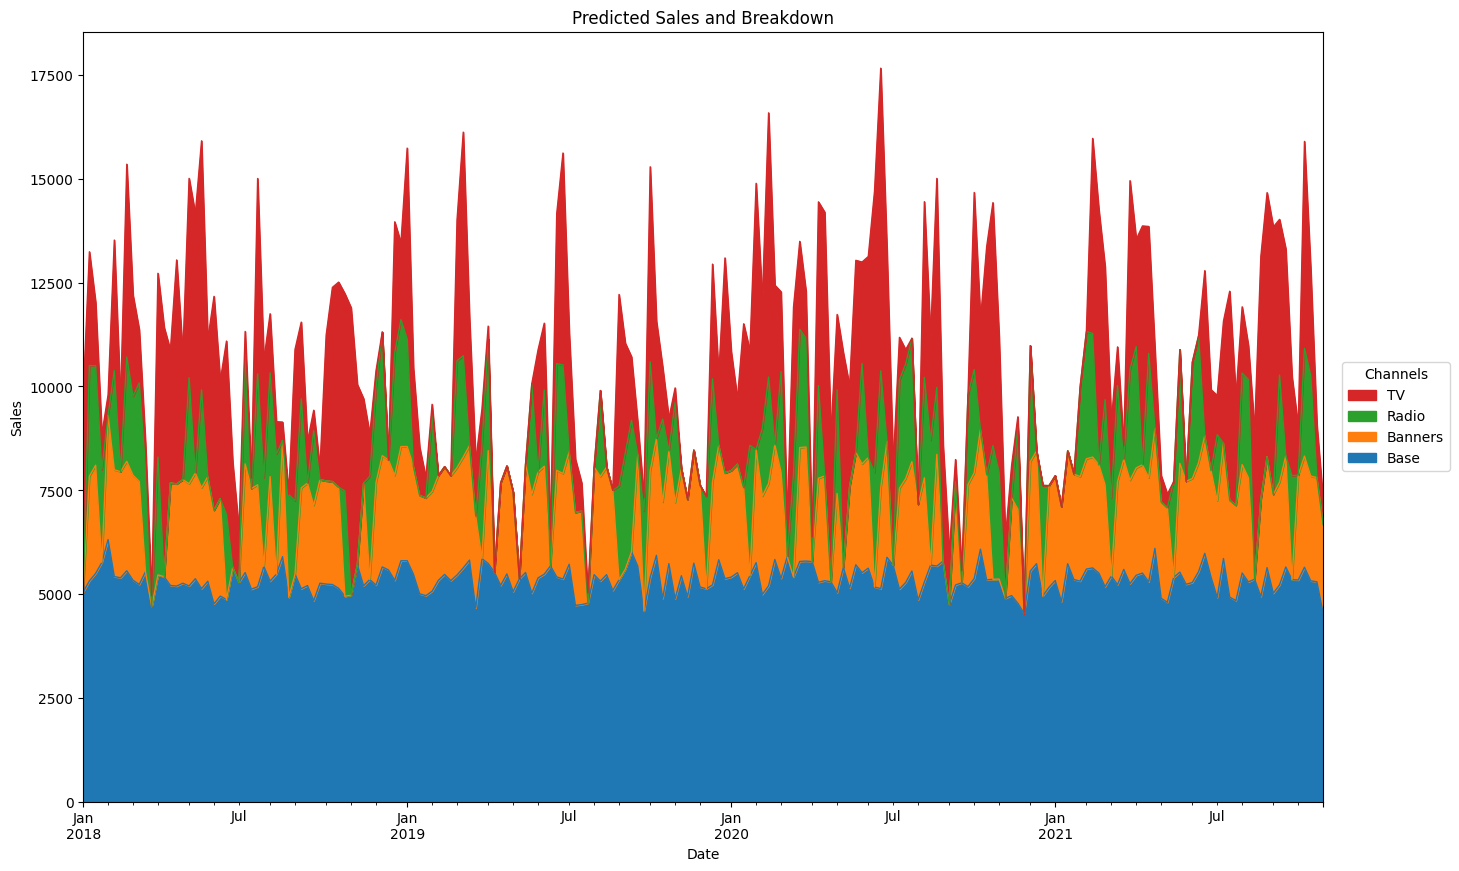

In [20]:
adstock_data = pd.DataFrame(
    tuned_model.best_estimator_.named_steps['adstock'].transform(X),
    columns=X.columns,
    index=X.index
)
weights = pd.Series(
    tuned_model.best_estimator_.named_steps['regression'].coef_,
    index=X.columns
)
base = tuned_model.best_estimator_.named_steps['regression'].intercept_
unadj_contributions = adstock_data.mul(weights).assign(Base=base)
adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    )
ax = (adj_contributions[['Base', 'Banners', 'Radio', 'TV']]
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Sales and Breakdown',
          ylabel='Sales',
          xlabel='Date'
      )
     )
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)